In [708]:
from pandas import read_csv
import numpy as np
from matplotlib.pyplot import hist, show, scatter
from numpy import mean, min, max, median, quantile
from scipy.stats import binom, norm, t as student, chi2
from math import sqrt, pow, floor, ceil

In [709]:
data = 'data'
data_ex1 = f'{data}\\data_ex1.csv'

ex1 = read_csv(data_ex1, header=None)
values = ex1.to_numpy()[:, 0]
values = sorted(values)

In [710]:
# define corrected functions for std and variance
def variance(values):
    return np.var(values, ddof=1)
def std(values):
    return np.std(values, ddof=1)

In [711]:
def quantile_confidence(values, q, confidence):
    # return tuple (lower, upper) of values
    values = sorted(values)
    n = len(values)
    if n > 100:
        # approximate
        z = norm.ppf((1+confidence)/2)
        j = floor(n*q-z*sqrt(n*q*(1-q)))
        k = ceil(n*q+z*sqrt(n*q*(1-q)))+1
        return (values[j], values[k], confidence)

    results = []
    # use dynamic
    for j in range(1, n):
        for k in range(j, n):
            val = binom.cdf(k, n, 0.5)-binom.cdf(j, n, 0.5)
            if val >= confidence:
                results.append((j, k, val))

    results = sorted(results, key=lambda x: (x[1]-x[0], -x[2]))
    return (values[results[0]], values[results[1]])


In [712]:
print("Median:", median(values))
interval = quantile_confidence(values, 0.5, 0.95)
print(f"CI at 0.95: [{interval[0]} - {interval[1]}]")

Median: 0.40319100366316096
CI at 0.95: [0.384475528575523 - 0.4171819583272271]


In [713]:
def mean_confidence_asymptotic(values, confidence):
    # when variables iid and high n
    n = len(values)
    z = norm.ppf((1+confidence)/2)
    s = std(values)
    m = mean(values)
    j = m - z*s/sqrt(n)
    k = m + z*s/sqrt(n)
    return (j, k)

In [714]:
# 1000 iid values => asymptotic
print(f"Mean: {mean(values)}")
interval = mean_confidence_asymptotic(values, 0.95)
print(f"Mean CI at 0.95: [{interval[0]} - {interval[1]}]")
interval = mean_confidence_asymptotic(values, 0.99)
print(f"Mean CI at 0.99: [{interval[0]} - {interval[1]}]")

Mean: 0.41020458058272363
Mean CI at 0.95: [0.398868829144219 - 0.42154033202122826]
Mean CI at 0.99: [0.3953068778885086 - 0.42510228327693866]


In [715]:
data_ex2 = f'{data}\\data_ex2.csv'
ex2 = read_csv(data_ex2, header=None)
rows = ex2.to_numpy()

In [716]:
# 200 values => asymptotic again
values = rows[0]
print("var", variance(values))
print(f"Mean: {mean(values)}")
interval = mean_confidence_asymptotic(values, 0.95)
print(f"Mean CI at 0.95: [{interval[0]} - {interval[1]}]")

var 2.938079099198786
Mean: 3.175048214082969
Mean CI at 0.95: [2.9374928534666043 - 3.4126035746993337]


In [717]:
outside = 0
inside = 0
for i in range(1, 6000):
    m = mean(rows[i])
    if m >= interval[0] and m <= interval[1]:
        inside += 1
    else:
        outside += 1

print(f"Ratio of rows with mean inside CI 0.95: {inside/(inside+outside)}")

Ratio of rows with mean inside CI 0.95: 0.6692782130355059


In [718]:
data_ex3 = f'{data}\\data_ex3.csv'
ex3 = read_csv(data_ex3, header=None)
values = ex3.to_numpy()[:,0]
values = sorted(values)

In [719]:
def CoV(values):
    # Coeff of variation (not defined on heavy tailed sets, because variance=>inf)
    return std(values)/mean(values)

def MAD(values):
    # mean absolute deviation, always defined
    n = len(values)
    m = mean(values)
    return sum([abs(x-m) for x in values])/n

def lorenz_gap(values):
    # always defined, the best
    return MAD(values)/(2*mean(values))

def JFI(values):
    # Jain Fairness Index (same problems as CoV?)
    return 1/(1+pow(CoV(values), 2))

In [720]:
print(f"CoV: {CoV(values)}")
print(f"Lorenz gap: {lorenz_gap(values)}")
print(f"Jain FI: {JFI(values)}")

CoV: 1.001469136252603
Lorenz gap: 0.36230444707595705
Jain FI: 0.49926597146344925


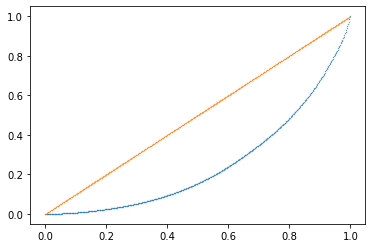

In [721]:
# plot lorenz
n = len(values)
curve = []
line = []
tot = sum(values)
cum_sum = np.cumsum(values)
for i in np.arange(0, n, 1):
    line.append(i/n)
    curve.append(cum_sum[i]/tot)

scatter(line, curve, s=0.1)
scatter(line, line, s=0.1)
show()

In [722]:

def bootstrap(values, confidence, func, r0=25):
    R = ceil(2*r0/(1-confidence))
    n = len(values)
    Tvs = []
    for r in range(R):
        V = np.random.choice(values, size=(n,))
        Tv = func(V)
        Tvs.append(Tv)
    Tvs = sorted(Tvs)
    interval = (Tvs[r0], Tvs[R-r0-1])
    low = 0
    high = 0
    for tv in Tvs:
        if tv < interval[0]:
            low += 1
        if tv > interval[1]:
            high += 1
    return interval

print(f"Lorenz gap: {lorenz_gap(values)}")
interval = bootstrap(values, 0.95, lorenz_gap)
print(f"Lorenz gap CI at 0.95: [{interval[0]} - {interval[1]}]")
interval = bootstrap(values, 0.99, lorenz_gap)
print(f"Lorenz gap CI at 0.99: [{interval[0]} - {interval[1]}]\n")

print(f"Jain FI: {JFI(values)}")
interval = bootstrap(values, 0.95, JFI)
print(f"Jain FI CI at 0.95: [{interval[0]} - {interval[1]}]")
interval = bootstrap(values, 0.99, JFI)
print(f"Jain FI CI at 0.99: [{interval[0]} - {interval[1]}]\n")

print(f"Mean: {mean(values)}")
interval = bootstrap(values, 0.95, mean)
print(f"Mean CI at 0.95: [{interval[0]} - {interval[1]}]")
interval = bootstrap(values, 0.99, mean)
print(f"Mean CI at 0.99: [{interval[0]} - {interval[1]}]\n")

print(f"Std: {std(values)}")
interval = bootstrap(values, 0.95, std)
print(f"Std CI at 0.95: [{interval[0]} - {interval[1]}]")
interval = bootstrap(values, 0.99, std)
print(f"Std CI at 0.99: [{interval[0]} - {interval[1]}]\n")

Lorenz gap: 0.36230444707595705
Lorenz gap CI at 0.95: [0.34108461501279647 - 0.3838568355508831]
Lorenz gap CI at 0.99: [0.333914233960417 - 0.39222803412067353]

Jain FI: 0.49926597146344925
Jain FI CI at 0.95: [0.4550627951979846 - 0.5487642976658562]
Jain FI CI at 0.99: [0.4452885782431641 - 0.5577088193585574]

Mean: 4.084097581606042
Mean CI at 0.95: [3.7280940367597046 - 4.441779417624064]
Mean CI at 0.99: [3.646398694003481 - 4.556271246944436]

Std: 4.090097677422348
Std CI at 0.95: [3.5770743237719262 - 4.596027472218183]
Std CI at 0.99: [3.4350036301178406 - 4.788839619220645]



In [723]:
# compare bootstrap mean with asymptotic mean
interval = mean_confidence_asymptotic(values, 0.95)
print(f"Mean CI at 0.95: [{interval[0]} - {interval[1]}]")
interval = mean_confidence_asymptotic(values, 0.99)
print(f"Mean CI at 0.99: [{interval[0]} - {interval[1]}]\n")

# bootstrap has smaller interval

Mean CI at 0.95: [3.7255913008639814 - 4.442603862348103]
Mean CI at 0.99: [3.612940463043766 - 4.555254700168319]

